# Understanding Batch Normalization: A Comprehensive Experimental Study

This notebook provides deep insights into **why batch normalization works** through hands-on experiments on a real dataset (CIFAR-10).

## What We'll Explore:

1. **The Problem**: Internal Covariate Shift and unstable training
2. **The Solution**: How BatchNorm normalizes activations
3. **Experiments**:
   - Training dynamics with vs without BatchNorm
   - Activation distribution changes during training
   - Gradient flow analysis
   - Learning rate sensitivity
   - Effect on convergence speed

## Key Questions We'll Answer:
- Why do deep networks train poorly without normalization?
- How does BatchNorm stabilize training?
- Why can we use higher learning rates with BatchNorm?
- What happens to activation distributions during training?

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import time
from tqdm.auto import tqdm

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


## 1. Weights & Biases Configuration (Optional)

Set `USE_WANDB = True` and configure your project details to enable experiment tracking.

In [3]:
# ============================================
# WEIGHTS & BIASES CONFIGURATION
# ============================================
# Set to True to enable W&B logging
USE_WANDB = True
# 00cb546652f2025d121f19802d5844f329eb1b3f
# Configure these when running the experiment:
WANDB_PROJECT = "batch-normalization-study"  # Your W&B project name
WANDB_ENTITY = "phoenix_nlp"  # Your W&B username or team name (None for default)

if USE_WANDB:
    try:
        import wandb
        wandb.login()  # Will prompt for API key if not logged in
        print("W&B initialized successfully!")
    except ImportError:
        print("wandb not installed. Run: pip install wandb")
        USE_WANDB = False
else:
    print("W&B disabled. Set USE_WANDB = True to enable experiment tracking.")

wandb: Currently logged in as: iqbal_shaik (phoenix_nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B initialized successfully!


## 2. Load CIFAR-10 Dataset

CIFAR-10 is ideal for this study because:
- Real-world images (not synthetic)
- Challenging enough to show BatchNorm benefits
- Fast enough to run multiple experiments

In [4]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Use a subset for faster experiments (adjust as needed)
TRAIN_SUBSET_SIZE = 10000  # Use 10k samples for faster iteration
TEST_SUBSET_SIZE = 2000

train_indices = np.random.choice(len(trainset), TRAIN_SUBSET_SIZE, replace=False)
test_indices = np.random.choice(len(testset), TEST_SUBSET_SIZE, replace=False)

trainset_subset = Subset(trainset, train_indices)
testset_subset = Subset(testset, test_indices)

# Create data loaders
BATCH_SIZE = 128
trainloader = DataLoader(trainset_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset_subset)}")
print(f"Test samples: {len(testset_subset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Batches per epoch: {len(trainloader)}")

100.0%


Training samples: 10000
Test samples: 2000
Batch size: 128
Batches per epoch: 79


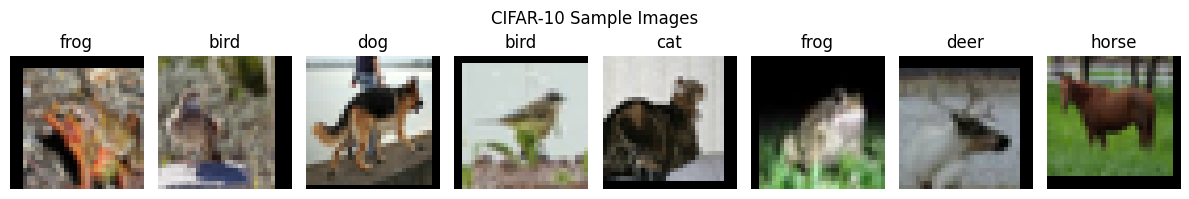

In [5]:
# Visualize some samples
def show_samples(loader, n=8):
    images, labels = next(iter(loader))
    
    # Denormalize for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    images_denorm = images[:n] * std + mean
    
    fig, axes = plt.subplots(1, n, figsize=(12, 2))
    for i in range(n):
        axes[i].imshow(images_denorm[i].permute(1, 2, 0).numpy().clip(0, 1))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.suptitle('CIFAR-10 Sample Images')
    plt.tight_layout()
    plt.show()

show_samples(trainloader)

## 3. Define CNN Architectures

We'll create two versions of the same CNN:
1. **Without Batch Normalization** - Standard CNN
2. **With Batch Normalization** - BatchNorm after each conv/fc layer

Both have **identical architecture** except for the normalization layers.

In [6]:
class ActivationTracker:
    """
    Tracks activation statistics during forward pass.
    This is key to understanding what BatchNorm does!
    """
    def __init__(self):
        self.activations = {}  # layer_name -> list of (mean, std, min, max)
        self.gradients = {}    # layer_name -> list of gradient norms
        self.hooks = []
        
    def register(self, model: nn.Module, layer_names: List[str]):
        """Register hooks to track activations."""
        for name, module in model.named_modules():
            if name in layer_names:
                self.activations[name] = []
                self.gradients[name] = []
                
                # Forward hook for activations
                def make_forward_hook(layer_name):
                    def hook(module, input, output):
                        with torch.no_grad():
                            act = output.detach()
                            self.activations[layer_name].append({
                                'mean': act.mean().item(),
                                'std': act.std().item(),
                                'min': act.min().item(),
                                'max': act.max().item(),
                                'histogram': act.cpu().numpy().flatten()
                            })
                    return hook
                
                # Backward hook for gradients
                def make_backward_hook(layer_name):
                    def hook(module, grad_input, grad_output):
                        with torch.no_grad():
                            if grad_output[0] is not None:
                                grad_norm = grad_output[0].norm().item()
                                self.gradients[layer_name].append(grad_norm)
                    return hook
                
                h1 = module.register_forward_hook(make_forward_hook(name))
                h2 = module.register_full_backward_hook(make_backward_hook(name))
                self.hooks.extend([h1, h2])
    
    def clear(self):
        """Clear recorded data."""
        for key in self.activations:
            self.activations[key] = []
        for key in self.gradients:
            self.gradients[key] = []
    
    def remove_hooks(self):
        """Remove all hooks."""
        for h in self.hooks:
            h.remove()
        self.hooks = []

In [7]:
class CNN_NoBatchNorm(nn.Module):
    """
    CNN without Batch Normalization.
    This will show unstable training, especially with high learning rates.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Named activation layers for tracking
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        self.act4 = nn.ReLU()
        self.act_fc1 = nn.ReLU()
        
    def forward(self, x):
        # Conv block 1: 32x32 -> 16x16
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)
        
        # Conv block 2: 16x16 -> 8x8
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool(x)
        
        # Conv block 3: 8x8 -> 4x4
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool(x)
        
        # Conv block 4: 4x4 -> 2x2
        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool(x)
        
        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_trackable_layers(self):
        """Return layer names to track."""
        return ['act1', 'act2', 'act3', 'act4', 'act_fc1']

In [8]:
class CNN_WithBatchNorm(nn.Module):
    """
    CNN with Batch Normalization after each conv/fc layer.
    This demonstrates stable training and faster convergence.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers with BatchNorm
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Named activation layers for tracking
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        self.act4 = nn.ReLU()
        self.act_fc1 = nn.ReLU()
        
    def forward(self, x):
        # Conv block 1: 32x32 -> 16x16
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool(x)
        
        # Conv block 2: 16x16 -> 8x8
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool(x)
        
        # Conv block 3: 8x8 -> 4x4
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.pool(x)
        
        # Conv block 4: 4x4 -> 2x2
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.pool(x)
        
        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.act_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_trackable_layers(self):
        """Return layer names to track."""
        return ['act1', 'act2', 'act3', 'act4', 'act_fc1']

In [9]:
# Compare model architectures
model_no_bn = CNN_NoBatchNorm()
model_with_bn = CNN_WithBatchNorm()

def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("Model Comparison:")
print(f"  Without BatchNorm: {count_params(model_no_bn):,} parameters")
print(f"  With BatchNorm:    {count_params(model_with_bn):,} parameters")
print(f"  BatchNorm adds:    {count_params(model_with_bn) - count_params(model_no_bn):,} parameters")

Model Comparison:
  Without BatchNorm: 918,346 parameters
  With BatchNorm:    920,330 parameters
  BatchNorm adds:    1,984 parameters


## 4. Training Infrastructure

We'll create a training function that:
- Records loss and accuracy curves
- Optionally tracks activation distributions
- Optionally logs to Weights & Biases

In [10]:
def train_model(
    model: nn.Module,
    trainloader: DataLoader,
    testloader: DataLoader,
    epochs: int = 20,
    lr: float = 0.01,
    model_name: str = "model",
    track_activations: bool = False,
    track_every_n_batches: int = 10,
    use_wandb: bool = False,
) -> Dict:
    """
    Train a model and record comprehensive metrics.
    
    Returns:
        Dictionary with training history and activation statistics
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # Initialize W&B run if enabled
    if use_wandb and USE_WANDB:
        wandb.init(
            project=WANDB_PROJECT,
            entity=WANDB_ENTITY,
            name=f"{model_name}_lr{lr}",
            config={
                "model": model_name,
                "learning_rate": lr,
                "epochs": epochs,
                "batch_size": BATCH_SIZE,
                "optimizer": "SGD",
                "momentum": 0.9,
            }
        )
    
    # Set up activation tracking
    tracker = None
    if track_activations:
        tracker = ActivationTracker()
        tracker.register(model, model.get_trackable_layers())
    
    # History
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch_time': [],
        'activation_stats': defaultdict(list),  # layer -> list of stats per epoch
        'gradient_stats': defaultdict(list),    # layer -> list of grad norms per epoch
    }
    
    global_step = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_start = time.time()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
            
            # Log to W&B
            if use_wandb and USE_WANDB:
                wandb.log({
                    'batch_loss': loss.item(),
                    'batch_acc': 100. * predicted.eq(labels).sum().item() / labels.size(0),
                }, step=global_step)
            
            global_step += 1
        
        # Compute epoch metrics
        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
        
        test_loss = test_loss / len(testloader)
        test_acc = 100. * test_correct / test_total
        epoch_time = time.time() - epoch_start
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['epoch_time'].append(epoch_time)
        
        # Record activation statistics
        if tracker:
            for layer_name, act_list in tracker.activations.items():
                if act_list:
                    # Get statistics from last batch
                    stats = act_list[-1]
                    history['activation_stats'][layer_name].append({
                        'mean': stats['mean'],
                        'std': stats['std'],
                        'min': stats['min'],
                        'max': stats['max'],
                    })
            
            for layer_name, grad_list in tracker.gradients.items():
                if grad_list:
                    avg_grad = np.mean(grad_list[-100:])  # Average of last 100 batches
                    history['gradient_stats'][layer_name].append(avg_grad)
            
            tracker.clear()  # Clear for next epoch
        
        # Log epoch metrics to W&B
        if use_wandb and USE_WANDB:
            log_dict = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'epoch_time': epoch_time,
            }
            
            # Add activation stats
            if tracker:
                for layer_name in history['activation_stats']:
                    if history['activation_stats'][layer_name]:
                        stats = history['activation_stats'][layer_name][-1]
                        log_dict[f'{layer_name}/mean'] = stats['mean']
                        log_dict[f'{layer_name}/std'] = stats['std']
            
            wandb.log(log_dict, step=global_step)
        
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%, Time={epoch_time:.2f}s")
    
    # Clean up
    if tracker:
        tracker.remove_hooks()
    
    if use_wandb and USE_WANDB:
        wandb.finish()
    
    return history

## 5. Experiment 1: Training Dynamics Comparison

Let's train both models with the same hyperparameters and compare:
- Training/test loss curves
- Accuracy progression
- Convergence speed

In [11]:
# Train both models with moderate learning rate
LEARNING_RATE = 0.01
EPOCHS = 20

print("=" * 60)
print("Training CNN WITHOUT Batch Normalization")
print("=" * 60)
model_no_bn = CNN_NoBatchNorm().to(device)
history_no_bn = train_model(
    model_no_bn, trainloader, testloader,
    epochs=EPOCHS, lr=LEARNING_RATE,
    model_name="CNN_NoBatchNorm",
    track_activations=True,
    use_wandb=USE_WANDB,
)

print("\n" + "=" * 60)
print("Training CNN WITH Batch Normalization")
print("=" * 60)
model_with_bn = CNN_WithBatchNorm().to(device)
history_with_bn = train_model(
    model_with_bn, trainloader, testloader,
    epochs=EPOCHS, lr=LEARNING_RATE,
    model_name="CNN_WithBatchNorm",
    track_activations=True,
    use_wandb=USE_WANDB,
)

Training CNN WITHOUT Batch Normalization


Epoch 1/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=2.2890, Train Acc=12.07%, Test Loss=2.2499, Test Acc=16.70%, Time=40.60s


Epoch 2/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=2.1202, Train Acc=21.84%, Test Loss=1.9745, Test Acc=24.45%, Time=33.38s


Epoch 3/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=1.9878, Train Acc=26.30%, Test Loss=1.8575, Test Acc=29.35%, Time=32.46s


Epoch 4/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.8584, Train Acc=29.76%, Test Loss=1.7848, Test Acc=33.65%, Time=32.19s


Epoch 5/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.7905, Train Acc=32.68%, Test Loss=1.7685, Test Acc=35.95%, Time=33.30s


Epoch 6/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.6763, Train Acc=37.05%, Test Loss=1.5893, Test Acc=40.95%, Time=72.49s


Epoch 7/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.6267, Train Acc=39.55%, Test Loss=1.5331, Test Acc=43.50%, Time=33.12s


Epoch 8/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.5964, Train Acc=41.57%, Test Loss=1.5082, Test Acc=44.30%, Time=32.83s


Epoch 9/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=1.5202, Train Acc=44.14%, Test Loss=1.5611, Test Acc=42.90%, Time=32.48s


Epoch 10/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=1.4802, Train Acc=45.04%, Test Loss=1.3564, Test Acc=50.25%, Time=32.36s


Epoch 11/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=1.4125, Train Acc=47.76%, Test Loss=1.3187, Test Acc=52.70%, Time=32.58s


Epoch 12/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=1.3871, Train Acc=49.91%, Test Loss=1.3380, Test Acc=51.90%, Time=82.03s


Epoch 13/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=1.3474, Train Acc=50.79%, Test Loss=1.2877, Test Acc=54.65%, Time=32.45s


Epoch 14/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=1.3109, Train Acc=52.25%, Test Loss=1.2916, Test Acc=55.45%, Time=32.17s


Epoch 15/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=1.2639, Train Acc=53.78%, Test Loss=1.1757, Test Acc=58.35%, Time=33.18s


Epoch 16/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 16: Train Loss=1.2255, Train Acc=55.39%, Test Loss=1.1938, Test Acc=57.75%, Time=32.25s


Epoch 17/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 17: Train Loss=1.2017, Train Acc=57.08%, Test Loss=1.1749, Test Acc=58.25%, Time=32.83s


Epoch 18/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 18: Train Loss=1.1636, Train Acc=58.17%, Test Loss=1.1534, Test Acc=59.75%, Time=83.36s


Epoch 19/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 19: Train Loss=1.1407, Train Acc=58.54%, Test Loss=1.0965, Test Acc=61.70%, Time=32.25s


Epoch 20/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 20: Train Loss=1.1109, Train Acc=60.09%, Test Loss=1.0402, Test Acc=63.75%, Time=32.51s


act1/mean,▃█▅▄▂▃▁▁▁▁▁▁▂▂▂▁▃▃▂▃
act1/std,▁▄▃▃▂▂▂▂▃▃▄▄▅▆▆▆▇▇██
act2/mean,▁▇▇▆▆██▆███▇████▇▇▇█
act2/std,▁▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
act3/mean,▁█▇▆▇█▇▆▆▆▆▅▄▄▄▃▃▃▄▄
act3/std,▁▇▇▇▇█▇▇███▇▇██▇▇▇██
act4/mean,▁██▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▂▂
act4/std,▁███▇▇▆▆▆▆▆▆▆▅▆▅▆▅▆▆
act_fc1/mean,▁▆▆▆▆▇▆▇▇▇▇▆▆▆▇▆▇▇██
act_fc1/std,▁▆▆▆▇▇▇▇▇▇█▆▇▇▇▇▇▇██
+8,...



Training CNN WITH Batch Normalization


Epoch 1/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=1.7944, Train Acc=33.83%, Test Loss=1.5568, Test Acc=42.75%, Time=35.84s


Epoch 2/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=1.5163, Train Acc=44.21%, Test Loss=1.3327, Test Acc=50.80%, Time=32.69s


Epoch 3/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=1.3496, Train Acc=51.53%, Test Loss=1.3459, Test Acc=50.05%, Time=32.64s


Epoch 4/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.2605, Train Acc=54.67%, Test Loss=1.2470, Test Acc=55.65%, Time=82.38s


Epoch 5/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.1901, Train Acc=57.34%, Test Loss=1.1567, Test Acc=57.65%, Time=32.15s


Epoch 6/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.1267, Train Acc=59.75%, Test Loss=1.1902, Test Acc=57.80%, Time=33.16s


Epoch 7/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.0679, Train Acc=61.66%, Test Loss=0.9768, Test Acc=64.75%, Time=32.75s


Epoch 8/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.0025, Train Acc=64.63%, Test Loss=1.1850, Test Acc=58.90%, Time=32.89s


Epoch 9/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=1.0148, Train Acc=64.27%, Test Loss=1.0785, Test Acc=62.50%, Time=32.93s


Epoch 10/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=0.9782, Train Acc=64.55%, Test Loss=1.0468, Test Acc=62.90%, Time=82.30s


Epoch 11/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=0.9126, Train Acc=67.75%, Test Loss=0.9713, Test Acc=65.90%, Time=32.21s


Epoch 12/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=0.8729, Train Acc=69.06%, Test Loss=0.8878, Test Acc=68.20%, Time=32.64s


Epoch 13/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=0.8462, Train Acc=70.07%, Test Loss=0.9582, Test Acc=66.75%, Time=32.34s


Epoch 14/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=0.8248, Train Acc=70.43%, Test Loss=0.9084, Test Acc=68.20%, Time=33.55s


Epoch 15/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=0.7986, Train Acc=71.83%, Test Loss=0.8645, Test Acc=70.65%, Time=32.91s


Epoch 16/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 16: Train Loss=0.7852, Train Acc=72.26%, Test Loss=0.8308, Test Acc=71.10%, Time=83.44s


Epoch 17/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 17: Train Loss=0.7714, Train Acc=72.74%, Test Loss=0.8379, Test Acc=70.95%, Time=32.37s


Epoch 18/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 18: Train Loss=0.7477, Train Acc=73.66%, Test Loss=0.7841, Test Acc=72.75%, Time=32.50s


Epoch 19/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 19: Train Loss=0.7056, Train Acc=74.95%, Test Loss=0.8231, Test Acc=71.55%, Time=33.27s


Epoch 20/20:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 20: Train Loss=0.6986, Train Acc=75.67%, Test Loss=0.7753, Test Acc=73.80%, Time=33.36s


act1/mean,█▆▇▆▆▄▄▅▄▃▄▃▂▂▂▂▂▁▁▁
act1/std,█▄▇▄▅▄▅▅▃▃▅▄▃▁▃▂▃▁▁▁
act2/mean,█▆▅▄▃▆▅▅▄▅▆▃▄▆▄▂▂▃▁▁
act2/std,█▆▅▄▄▄▄▄▃▄▅▃▃▃▃▂▂▂▁▁
act3/mean,▁▅▄▆▂▅█▇▄▅█▃▄▇▃▄▄▅▄▃
act3/std,▇▅▄▅▁▄▆▆▂▄█▁▄▅▃▄▃▄▂▂
act4/mean,▆▇▃▅▁▆▆▇▃▄█▃▅▅▄▃▁▄▃▂
act4/std,▇▆▃▅▁▅▆▇▃▅█▂▄▆▄▄▂▄▃▃
act_fc1/mean,▆█▃▄▃▅▃▄▃▄▆▄▃▃▂▆▃▁▃▂
act_fc1/std,▆█▂▄▂▇▄▅▃▃▇▃▃▄▃▆▂▁▂▂
+8,...


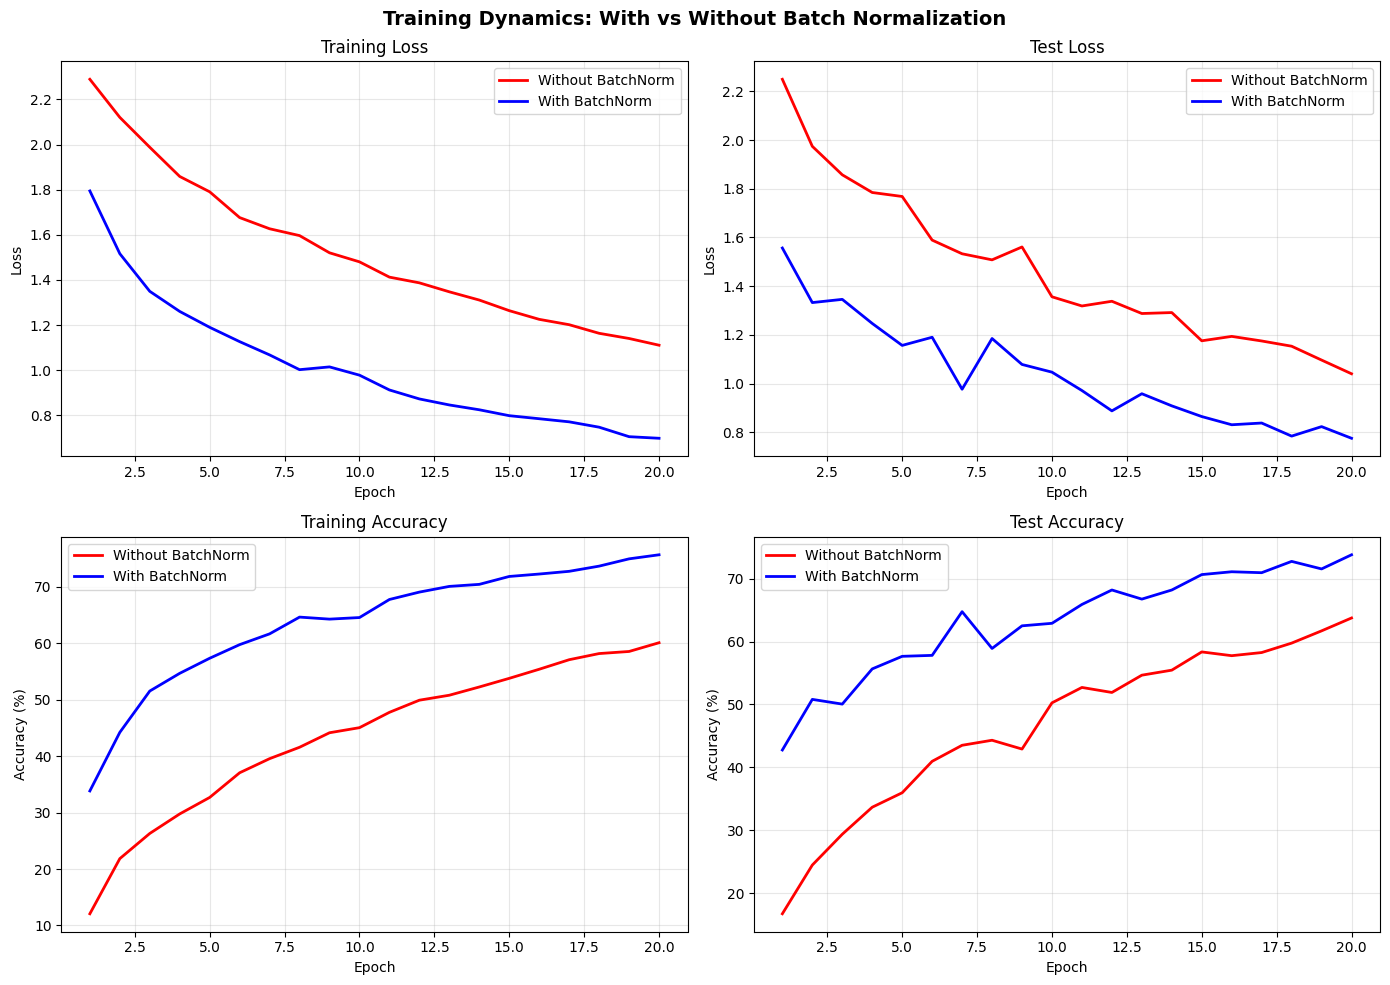


SUMMARY

Final Test Accuracy:
  Without BatchNorm: 63.75%
  With BatchNorm:    73.80%
  Improvement:       10.05%

Total Training Time:
  Without BatchNorm: 800.81s
  With BatchNorm:    808.31s


In [12]:
def plot_training_comparison(history_no_bn, history_with_bn):
    """Plot comprehensive training comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    epochs = range(1, len(history_no_bn['train_loss']) + 1)
    
    # Training Loss
    ax = axes[0, 0]
    ax.plot(epochs, history_no_bn['train_loss'], 'r-', label='Without BatchNorm', linewidth=2)
    ax.plot(epochs, history_with_bn['train_loss'], 'b-', label='With BatchNorm', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Test Loss
    ax = axes[0, 1]
    ax.plot(epochs, history_no_bn['test_loss'], 'r-', label='Without BatchNorm', linewidth=2)
    ax.plot(epochs, history_with_bn['test_loss'], 'b-', label='With BatchNorm', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Test Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Training Accuracy
    ax = axes[1, 0]
    ax.plot(epochs, history_no_bn['train_acc'], 'r-', label='Without BatchNorm', linewidth=2)
    ax.plot(epochs, history_with_bn['train_acc'], 'b-', label='With BatchNorm', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Test Accuracy
    ax = axes[1, 1]
    ax.plot(epochs, history_no_bn['test_acc'], 'r-', label='Without BatchNorm', linewidth=2)
    ax.plot(epochs, history_with_bn['test_acc'], 'b-', label='With BatchNorm', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Test Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Training Dynamics: With vs Without Batch Normalization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"\nFinal Test Accuracy:")
    print(f"  Without BatchNorm: {history_no_bn['test_acc'][-1]:.2f}%")
    print(f"  With BatchNorm:    {history_with_bn['test_acc'][-1]:.2f}%")
    print(f"  Improvement:       {history_with_bn['test_acc'][-1] - history_no_bn['test_acc'][-1]:.2f}%")
    
    print(f"\nTotal Training Time:")
    print(f"  Without BatchNorm: {sum(history_no_bn['epoch_time']):.2f}s")
    print(f"  With BatchNorm:    {sum(history_with_bn['epoch_time']):.2f}s")

plot_training_comparison(history_no_bn, history_with_bn)

## 6. Experiment 2: Activation Distribution Analysis

This is the **key insight** into why BatchNorm works!

We'll visualize:
- How activation distributions change across layers
- The "internal covariate shift" problem without BatchNorm
- How BatchNorm stabilizes distributions

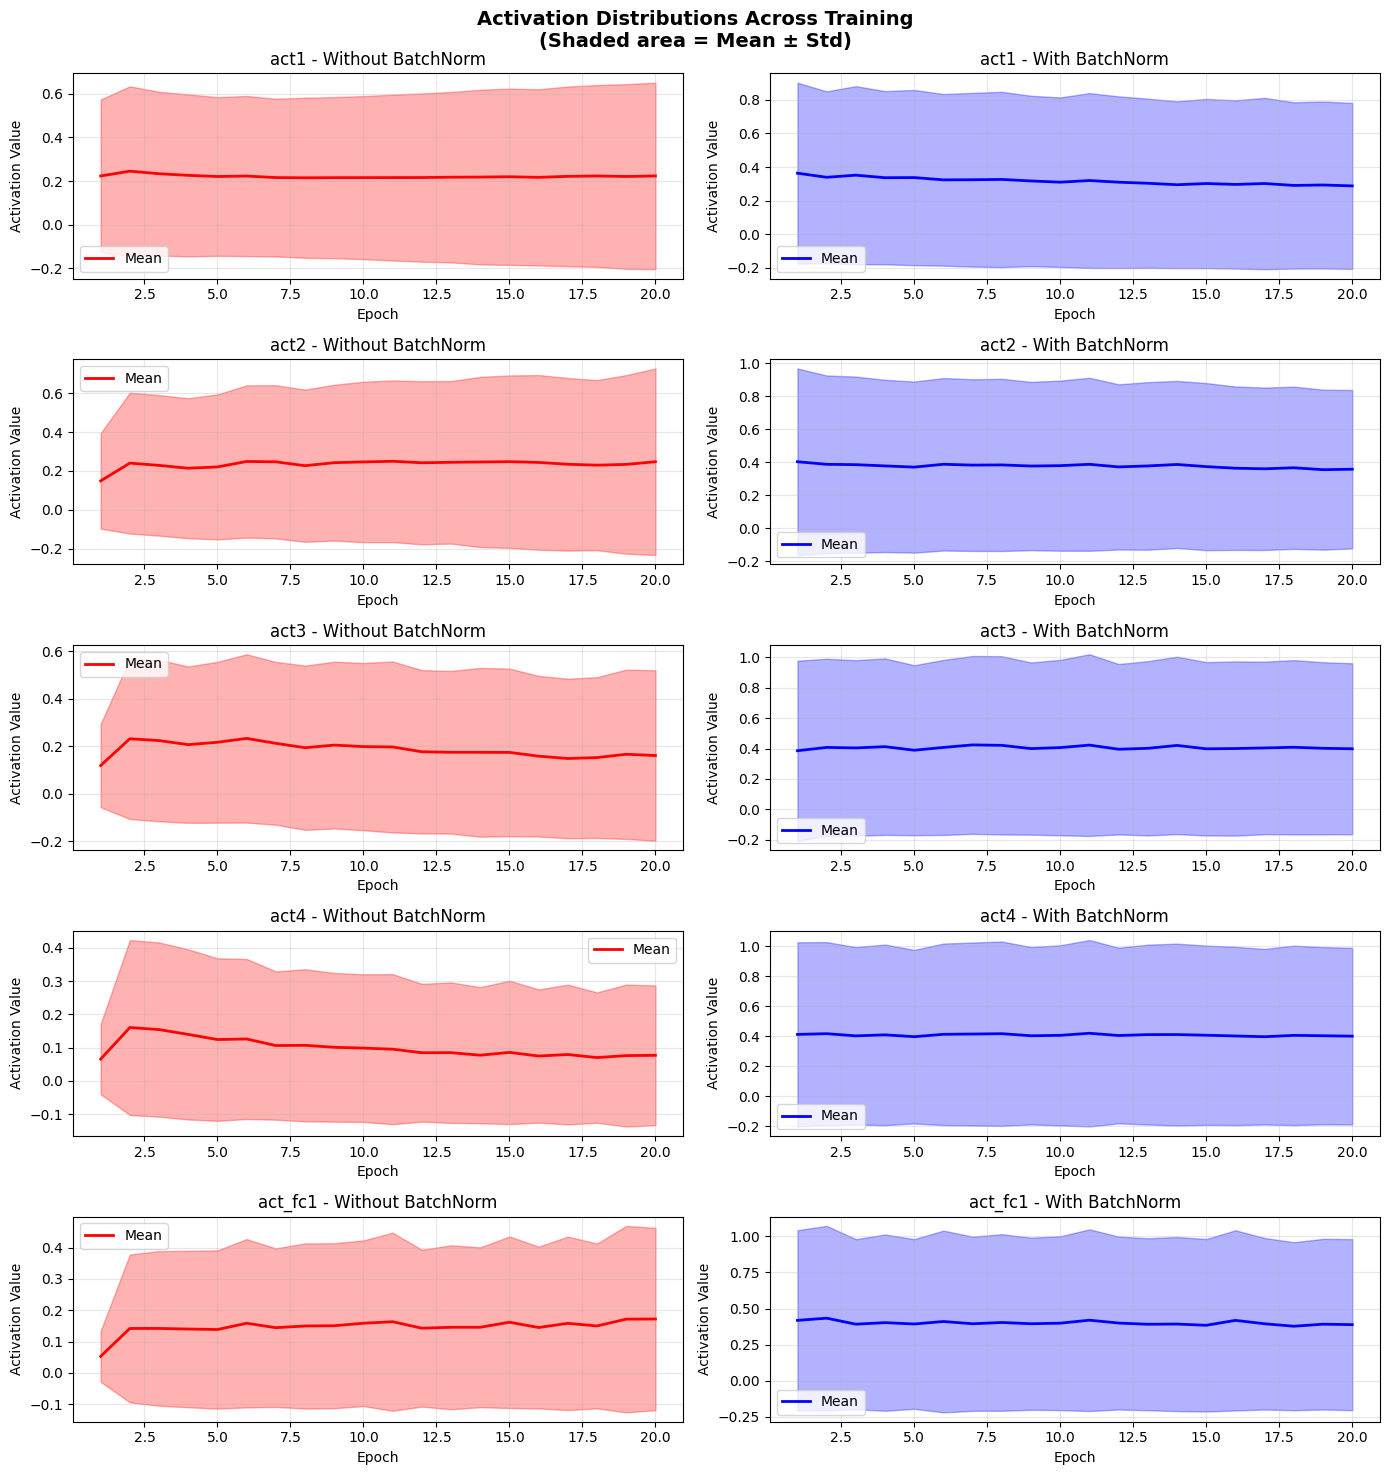

In [13]:
def plot_activation_distributions(history_no_bn, history_with_bn):
    """Visualize activation statistics across training."""
    
    layers = list(history_no_bn['activation_stats'].keys())
    if not layers:
        print("No activation stats recorded. Run training with track_activations=True")
        return
    
    fig, axes = plt.subplots(len(layers), 2, figsize=(14, 3 * len(layers)))
    
    for i, layer in enumerate(layers):
        # Without BatchNorm
        if layer in history_no_bn['activation_stats']:
            stats_no_bn = history_no_bn['activation_stats'][layer]
            epochs = range(1, len(stats_no_bn) + 1)
            
            means = [s['mean'] for s in stats_no_bn]
            stds = [s['std'] for s in stats_no_bn]
            
            ax = axes[i, 0]
            ax.fill_between(epochs, 
                           [m - s for m, s in zip(means, stds)],
                           [m + s for m, s in zip(means, stds)],
                           alpha=0.3, color='red')
            ax.plot(epochs, means, 'r-', linewidth=2, label='Mean')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Activation Value')
            ax.set_title(f'{layer} - Without BatchNorm')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # With BatchNorm
        if layer in history_with_bn['activation_stats']:
            stats_bn = history_with_bn['activation_stats'][layer]
            epochs = range(1, len(stats_bn) + 1)
            
            means = [s['mean'] for s in stats_bn]
            stds = [s['std'] for s in stats_bn]
            
            ax = axes[i, 1]
            ax.fill_between(epochs,
                           [m - s for m, s in zip(means, stds)],
                           [m + s for m, s in zip(means, stds)],
                           alpha=0.3, color='blue')
            ax.plot(epochs, means, 'b-', linewidth=2, label='Mean')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Activation Value')
            ax.set_title(f'{layer} - With BatchNorm')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Activation Distributions Across Training\n(Shaded area = Mean \u00b1 Std)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_activation_distributions(history_no_bn, history_with_bn)

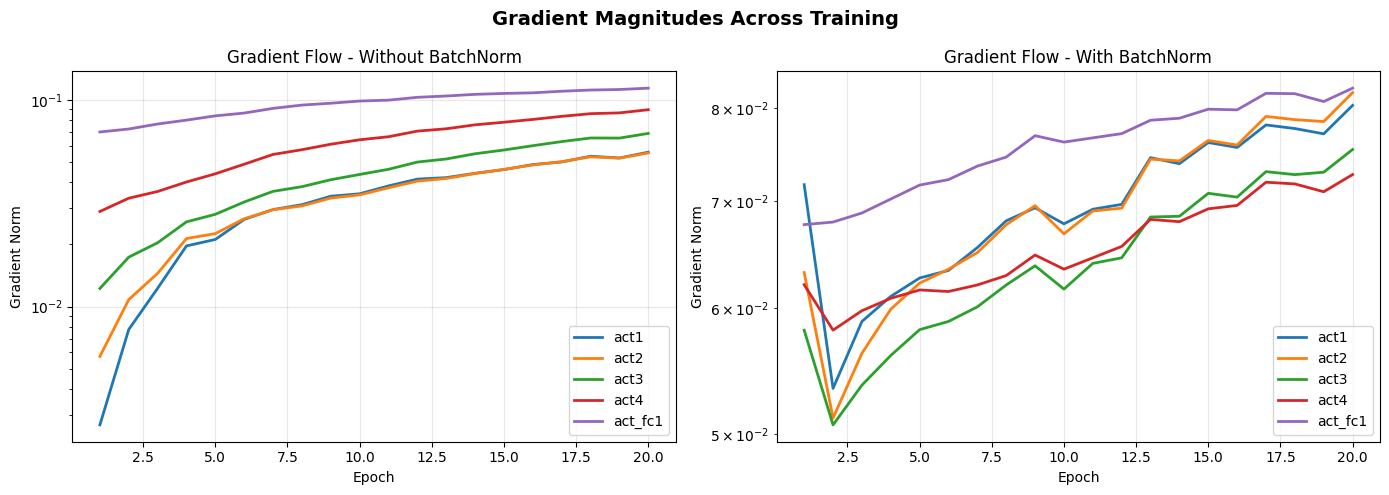

In [14]:
def plot_gradient_flow(history_no_bn, history_with_bn):
    """Visualize gradient magnitudes across layers and training."""
    
    layers = list(history_no_bn['gradient_stats'].keys())
    if not layers:
        print("No gradient stats recorded.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Without BatchNorm
    ax = axes[0]
    for layer in layers:
        if history_no_bn['gradient_stats'][layer]:
            grads = history_no_bn['gradient_stats'][layer]
            epochs = range(1, len(grads) + 1)
            ax.plot(epochs, grads, label=layer, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Gradient Flow - Without BatchNorm')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # With BatchNorm
    ax = axes[1]
    for layer in layers:
        if history_with_bn['gradient_stats'][layer]:
            grads = history_with_bn['gradient_stats'][layer]
            epochs = range(1, len(grads) + 1)
            ax.plot(epochs, grads, label=layer, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Gradient Flow - With BatchNorm')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.suptitle('Gradient Magnitudes Across Training', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_gradient_flow(history_no_bn, history_with_bn)

## 7. Experiment 3: Learning Rate Sensitivity

One of BatchNorm's biggest benefits is allowing **higher learning rates**.

Let's test how both models behave with different learning rates.

In [15]:
def learning_rate_experiment(learning_rates=[0.001, 0.01, 0.1], epochs=15):
    """
    Test different learning rates on both model types.
    This shows BatchNorm's tolerance for higher LRs.
    """
    results = {'no_bn': {}, 'with_bn': {}}
    
    for lr in learning_rates:
        print(f"\n{'='*60}")
        print(f"Testing Learning Rate: {lr}")
        print(f"{'='*60}")
        
        # Without BatchNorm
        print(f"\n--- Without BatchNorm (LR={lr}) ---")
        model = CNN_NoBatchNorm().to(device)
        try:
            history = train_model(
                model, trainloader, testloader,
                epochs=epochs, lr=lr,
                model_name=f"CNN_NoBatchNorm_lr{lr}",
                track_activations=False,
                use_wandb=USE_WANDB,
            )
            results['no_bn'][lr] = history
        except Exception as e:
            print(f"Training failed: {e}")
            results['no_bn'][lr] = None
        
        # With BatchNorm
        print(f"\n--- With BatchNorm (LR={lr}) ---")
        model = CNN_WithBatchNorm().to(device)
        try:
            history = train_model(
                model, trainloader, testloader,
                epochs=epochs, lr=lr,
                model_name=f"CNN_WithBatchNorm_lr{lr}",
                track_activations=False,
                use_wandb=USE_WANDB,
            )
            results['with_bn'][lr] = history
        except Exception as e:
            print(f"Training failed: {e}")
            results['with_bn'][lr] = None
    
    return results

# Run learning rate experiment
lr_results = learning_rate_experiment(
    learning_rates=[0.001, 0.01, 0.1],
    epochs=15
)


Testing Learning Rate: 0.001

--- Without BatchNorm (LR=0.001) ---


Epoch 1/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=2.3017, Train Acc=11.05%, Test Loss=2.3006, Test Acc=11.25%, Time=32.13s


Epoch 2/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=2.2994, Train Acc=11.53%, Test Loss=2.2982, Test Acc=10.25%, Time=31.38s


Epoch 3/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=2.2965, Train Acc=11.57%, Test Loss=2.2954, Test Acc=10.20%, Time=31.13s


Epoch 4/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=2.2925, Train Acc=11.54%, Test Loss=2.2914, Test Acc=10.30%, Time=30.33s


Epoch 5/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=2.2876, Train Acc=11.98%, Test Loss=2.2852, Test Acc=10.45%, Time=31.43s


Epoch 6/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=2.2790, Train Acc=13.06%, Test Loss=2.2749, Test Acc=14.20%, Time=31.13s


Epoch 7/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=2.2648, Train Acc=15.97%, Test Loss=2.2586, Test Acc=17.30%, Time=30.76s


Epoch 8/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=2.2417, Train Acc=18.31%, Test Loss=2.2311, Test Acc=21.00%, Time=30.56s


Epoch 9/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=2.2085, Train Acc=20.23%, Test Loss=2.1894, Test Acc=21.75%, Time=30.68s


Epoch 10/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=2.1586, Train Acc=21.45%, Test Loss=2.1335, Test Acc=23.65%, Time=30.85s


Epoch 11/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=2.1060, Train Acc=23.14%, Test Loss=2.0764, Test Acc=23.05%, Time=118.37s


Epoch 12/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=2.0703, Train Acc=23.49%, Test Loss=2.0547, Test Acc=25.15%, Time=30.16s


Epoch 13/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=2.0392, Train Acc=24.05%, Test Loss=2.0222, Test Acc=24.90%, Time=29.77s


Epoch 14/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=2.0243, Train Acc=24.31%, Test Loss=2.0189, Test Acc=27.15%, Time=30.19s


Epoch 15/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=2.0084, Train Acc=25.33%, Test Loss=1.9841, Test Acc=26.55%, Time=30.89s


batch_acc,▂▁▃▄▂▄▁▃▂▂▃▄▃▂▃▃▄▄▄▆▄▆▆▅▅▆▅▅▄▅▄▇▄▆▆▆▄▄█▅
batch_loss,████████████████▇▇▇█▇▇▇▇▇▆▅▄▅▄▅▅▅▂▅▃▃▁▄▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
test_acc,▁▁▁▁▁▃▄▅▆▇▆▇▇██
test_loss,█████▇▇▆▆▄▃▃▂▂▁
train_acc,▁▁▁▁▁▂▃▅▅▆▇▇▇▇█
train_loss,█████▇▇▇▆▅▃▂▂▁▁
batch_acc,6.25
batch_loss,2.0498
epoch,15



--- With BatchNorm (LR=0.001) ---


Epoch 1/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=1.9953, Train Acc=26.60%, Test Loss=1.7101, Test Acc=39.15%, Time=31.95s


Epoch 2/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=1.6940, Train Acc=37.71%, Test Loss=1.5370, Test Acc=44.70%, Time=30.91s


Epoch 3/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=1.5530, Train Acc=43.08%, Test Loss=1.4077, Test Acc=50.80%, Time=30.88s


Epoch 4/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.4635, Train Acc=46.38%, Test Loss=1.3715, Test Acc=50.95%, Time=31.42s


Epoch 5/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.3978, Train Acc=49.62%, Test Loss=1.3095, Test Acc=53.15%, Time=112.09s


Epoch 6/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.3568, Train Acc=51.28%, Test Loss=1.2519, Test Acc=55.65%, Time=30.19s


Epoch 7/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.3222, Train Acc=51.63%, Test Loss=1.2298, Test Acc=55.90%, Time=30.01s


Epoch 8/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.2640, Train Acc=54.77%, Test Loss=1.1723, Test Acc=58.90%, Time=29.95s


Epoch 9/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=1.2210, Train Acc=55.62%, Test Loss=1.1298, Test Acc=60.05%, Time=29.93s


Epoch 10/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=1.1778, Train Acc=58.00%, Test Loss=1.1220, Test Acc=60.05%, Time=30.24s


Epoch 11/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=1.1620, Train Acc=58.89%, Test Loss=1.1674, Test Acc=58.95%, Time=31.20s


Epoch 12/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=1.1221, Train Acc=60.36%, Test Loss=1.0859, Test Acc=60.90%, Time=31.33s


Epoch 13/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=1.1054, Train Acc=60.45%, Test Loss=1.0612, Test Acc=61.85%, Time=30.82s


Epoch 14/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=1.0749, Train Acc=62.19%, Test Loss=1.0774, Test Acc=60.85%, Time=31.31s


Epoch 15/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=1.0513, Train Acc=62.67%, Test Loss=1.0128, Test Acc=65.30%, Time=30.69s


batch_acc,▁▁▂▂▂▂▄▃▄▄▄▄▄▄▅▄▄▅▅▄▆▅▆▅▅▅▅▄▆▆▆▅▅▇▆▆▆▆▆█
batch_loss,▇██▆▇▆▇▅▆█▆▅▅▃▆▄▄▃▄▅▃▃▃▂▁▃▂▂▄▂▃▁▁▁▁▄▁▁▃▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
test_acc,▁▂▄▄▅▅▅▆▇▇▆▇▇▇█
test_loss,█▆▅▅▄▃▃▃▂▂▃▂▁▂▁
train_acc,▁▃▄▅▅▆▆▆▇▇▇████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
batch_acc,62.5
batch_loss,0.78234
epoch,15



Testing Learning Rate: 0.01

--- Without BatchNorm (LR=0.01) ---


Epoch 1/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=2.2924, Train Acc=11.91%, Test Loss=2.2581, Test Acc=18.70%, Time=29.64s


Epoch 2/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=2.1310, Train Acc=20.77%, Test Loss=1.9600, Test Acc=26.15%, Time=29.75s


Epoch 3/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=1.9357, Train Acc=26.67%, Test Loss=1.7740, Test Acc=33.05%, Time=29.81s


Epoch 4/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.8245, Train Acc=31.54%, Test Loss=1.7594, Test Acc=34.85%, Time=30.27s


Epoch 5/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.7533, Train Acc=34.49%, Test Loss=1.6456, Test Acc=39.40%, Time=30.31s


Epoch 6/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.6662, Train Acc=37.20%, Test Loss=1.5609, Test Acc=42.70%, Time=30.65s


Epoch 7/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.6007, Train Acc=41.00%, Test Loss=1.6185, Test Acc=41.95%, Time=30.54s


Epoch 8/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.5589, Train Acc=42.22%, Test Loss=1.4499, Test Acc=46.20%, Time=31.06s


Epoch 9/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=1.5006, Train Acc=44.15%, Test Loss=1.4071, Test Acc=48.55%, Time=30.77s


Epoch 10/15:   0%|          | 0/79 [01:23<?, ?it/s]

Epoch 10: Train Loss=1.4330, Train Acc=47.13%, Test Loss=1.4140, Test Acc=48.70%, Time=110.75s


Epoch 11/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=1.4099, Train Acc=48.24%, Test Loss=1.3762, Test Acc=50.70%, Time=29.67s


Epoch 12/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=1.3497, Train Acc=50.54%, Test Loss=1.2819, Test Acc=54.15%, Time=30.29s


Epoch 13/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=1.3325, Train Acc=51.24%, Test Loss=1.3107, Test Acc=53.30%, Time=30.14s


Epoch 14/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=1.2921, Train Acc=53.09%, Test Loss=1.2458, Test Acc=55.50%, Time=30.58s


Epoch 15/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=1.2527, Train Acc=54.53%, Test Loss=1.2249, Test Acc=55.80%, Time=30.63s


batch_acc,▁▁▂▁▂▃▂▃▂▄▃▃▃▄▄▄▄▄▄▅▄▅▅▆▅▆▇▆▇▇▆▇▇▇▆▇▇▇█▇
batch_loss,███▆▆▆▆▆▅▅▄▅▄▅▅▅▄▄▃▃▄▄▄▄▄▄▂▃▃▂▃▃▂▂▂▁▂▂▂▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
test_acc,▁▂▄▄▅▆▅▆▇▇▇████
test_loss,█▆▅▅▄▃▄▃▂▂▂▁▂▁▁
train_acc,▁▂▃▄▅▅▆▆▆▇▇▇▇██
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁
batch_acc,81.25
batch_loss,0.67439
epoch,15



--- With BatchNorm (LR=0.01) ---


Epoch 1/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=1.8044, Train Acc=33.56%, Test Loss=1.5420, Test Acc=43.35%, Time=31.50s


Epoch 2/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=1.5202, Train Acc=44.06%, Test Loss=1.4324, Test Acc=47.20%, Time=31.67s


Epoch 3/15:   0%|          | 0/79 [00:04<?, ?it/s]

Epoch 3: Train Loss=1.3659, Train Acc=50.48%, Test Loss=1.2467, Test Acc=54.70%, Time=31.99s


Epoch 4/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.2765, Train Acc=53.70%, Test Loss=1.2431, Test Acc=55.80%, Time=111.68s


Epoch 5/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.2132, Train Acc=56.47%, Test Loss=1.2447, Test Acc=55.35%, Time=30.45s


Epoch 6/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.1336, Train Acc=59.06%, Test Loss=1.1271, Test Acc=60.30%, Time=30.59s


Epoch 7/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.0595, Train Acc=62.11%, Test Loss=1.0499, Test Acc=62.75%, Time=30.43s


Epoch 8/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.0271, Train Acc=63.34%, Test Loss=0.9685, Test Acc=65.70%, Time=30.54s


Epoch 9/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=0.9754, Train Acc=65.22%, Test Loss=1.0331, Test Acc=63.85%, Time=30.97s


Epoch 10/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=0.9549, Train Acc=65.89%, Test Loss=0.9547, Test Acc=66.45%, Time=30.88s


Epoch 11/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=0.9016, Train Acc=67.77%, Test Loss=0.9768, Test Acc=66.05%, Time=31.44s


Epoch 12/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=0.8893, Train Acc=68.44%, Test Loss=0.9321, Test Acc=67.55%, Time=31.53s


Epoch 13/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=0.8677, Train Acc=69.15%, Test Loss=0.9191, Test Acc=67.80%, Time=31.28s


Epoch 14/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=0.8275, Train Acc=70.03%, Test Loss=0.8787, Test Acc=69.90%, Time=31.57s


Epoch 15/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=0.7853, Train Acc=71.97%, Test Loss=0.8470, Test Acc=71.70%, Time=31.48s


batch_acc,▁▁▃▃▃▃▄▄▄▄▅▄▅▅▅▄▆▆▅▆▆▆▇▆▆▆▇▇▇▇█▇▇▆▇█▆█▆▇
batch_loss,█▆▅▇▅▅▄▄▄▃▄▂▂▂▃▄▃▃▂▂▃▂▂▂▂▁▂▂▂▂▃▂▂▁▂▂▁▂▁▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▂▄▄▄▅▆▇▆▇▇▇▇██
test_loss,█▇▅▅▅▄▃▂▃▂▂▂▂▁▁
train_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇██
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁
batch_acc,43.75
batch_loss,1.0841
epoch,15



Testing Learning Rate: 0.1

--- Without BatchNorm (LR=0.1) ---


Epoch 1/15:   0%|          | 0/79 [00:04<?, ?it/s]

Epoch 1: Train Loss=2.1503, Train Acc=18.36%, Test Loss=1.9864, Test Acc=22.70%, Time=32.14s


Epoch 2/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=1.9835, Train Acc=25.08%, Test Loss=1.8239, Test Acc=35.20%, Time=30.18s


Epoch 3/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=1.8397, Train Acc=31.53%, Test Loss=1.8472, Test Acc=27.90%, Time=49.71s


Epoch 4/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.7832, Train Acc=33.25%, Test Loss=1.7002, Test Acc=38.85%, Time=29.84s


Epoch 5/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.7238, Train Acc=35.58%, Test Loss=1.7231, Test Acc=35.70%, Time=30.34s


Epoch 6/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.6750, Train Acc=37.75%, Test Loss=1.6415, Test Acc=39.90%, Time=30.54s


Epoch 7/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.6544, Train Acc=39.03%, Test Loss=1.5427, Test Acc=42.20%, Time=30.94s


Epoch 8/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.6455, Train Acc=39.21%, Test Loss=1.5769, Test Acc=43.95%, Time=30.83s


Epoch 9/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=1.6016, Train Acc=41.22%, Test Loss=1.5402, Test Acc=44.00%, Time=31.04s


Epoch 10/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=1.5964, Train Acc=41.61%, Test Loss=1.6728, Test Acc=41.75%, Time=30.79s


Epoch 11/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=1.6336, Train Acc=39.76%, Test Loss=1.5078, Test Acc=42.85%, Time=30.82s


Epoch 12/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=1.5611, Train Acc=42.90%, Test Loss=1.3929, Test Acc=49.85%, Time=30.56s


Epoch 13/15:   0%|          | 0/79 [00:03<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 13: Train Loss=1.5123, Train Acc=44.27%, Test Loss=1.4308, Test Acc=46.95%, Time=110.40s


Epoch 14/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=1.5490, Train Acc=43.87%, Test Loss=1.5248, Test Acc=42.50%, Time=29.73s


Epoch 15/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=1.5638, Train Acc=43.54%, Test Loss=1.4200, Test Acc=48.65%, Time=31.51s


batch_acc,▂▁▂▂▂▄▄▄▆▃▅▆▅▆▅▇▄▆█▇▇▆█▆▅▇▇▆▆▇▆██▇▇▇▆▇▇▄
batch_loss,█▆▆▆▅▅▅▄▄▅▃▄▂▃▃▃▂▃▃▂▂▃▃▃▃▃▅▃▃▁▃▁▃▂▂▂▃▂▄▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,▁▁▃▁▁▁▁▁▁▁▁▁█▁▁
test_acc,▁▄▂▅▄▅▆▆▆▆▆█▇▆█
test_loss,█▆▆▅▅▄▃▃▃▄▂▁▁▃▁
train_acc,▁▃▅▅▆▆▇▇▇▇▇████
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▂
batch_acc,56.25
batch_loss,1.58444
epoch,15



--- With BatchNorm (LR=0.1) ---


Epoch 1/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 1: Train Loss=2.4766, Train Acc=28.34%, Test Loss=2.4745, Test Acc=31.90%, Time=32.60s


Epoch 2/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 2: Train Loss=2.0054, Train Acc=37.49%, Test Loss=1.8075, Test Acc=40.55%, Time=31.38s


Epoch 3/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 3: Train Loss=1.6116, Train Acc=43.67%, Test Loss=1.4329, Test Acc=49.65%, Time=31.43s


Epoch 4/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 4: Train Loss=1.4157, Train Acc=49.44%, Test Loss=1.3700, Test Acc=48.90%, Time=31.53s


Epoch 5/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 5: Train Loss=1.3428, Train Acc=50.77%, Test Loss=1.2577, Test Acc=55.40%, Time=31.54s


Epoch 6/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 6: Train Loss=1.2321, Train Acc=55.64%, Test Loss=1.2584, Test Acc=56.00%, Time=31.76s


Epoch 7/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 7: Train Loss=1.1928, Train Acc=57.60%, Test Loss=1.1971, Test Acc=57.85%, Time=111.13s


Epoch 8/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 8: Train Loss=1.1530, Train Acc=58.81%, Test Loss=1.1628, Test Acc=59.85%, Time=30.31s


Epoch 9/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 9: Train Loss=1.0917, Train Acc=61.14%, Test Loss=1.0395, Test Acc=62.75%, Time=31.20s


Epoch 10/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 10: Train Loss=1.0411, Train Acc=62.65%, Test Loss=1.1152, Test Acc=61.45%, Time=31.38s


Epoch 11/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 11: Train Loss=1.0029, Train Acc=64.25%, Test Loss=0.9886, Test Acc=65.20%, Time=30.91s


Epoch 12/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 12: Train Loss=0.9565, Train Acc=66.16%, Test Loss=1.0409, Test Acc=63.05%, Time=31.34s


Epoch 13/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 13: Train Loss=0.9287, Train Acc=67.15%, Test Loss=1.0228, Test Acc=64.40%, Time=31.21s


Epoch 14/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 14: Train Loss=0.9041, Train Acc=67.74%, Test Loss=0.9580, Test Acc=67.95%, Time=31.98s


Epoch 15/15:   0%|          | 0/79 [00:03<?, ?it/s]

Epoch 15: Train Loss=0.8569, Train Acc=69.86%, Test Loss=1.0278, Test Acc=65.60%, Time=31.34s


batch_acc,▂▁▁▂▃▃▄▅▄▅▄▇▅▆▅▅▅▆▆▆▅▆▆▇▇▇▆▇▆▇▇█▆▆▇█▇▇▇█
batch_loss,▇█▇▆▅▄▄▄▃▃▂▃▃▃▂▁▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
test_acc,▁▃▄▄▆▆▆▆▇▇▇▇▇██
test_loss,█▅▃▃▂▂▂▂▁▂▁▁▁▁▁
train_acc,▁▃▄▅▅▆▆▆▇▇▇▇███
train_loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁
batch_acc,56.25
batch_loss,1.35405
epoch,15


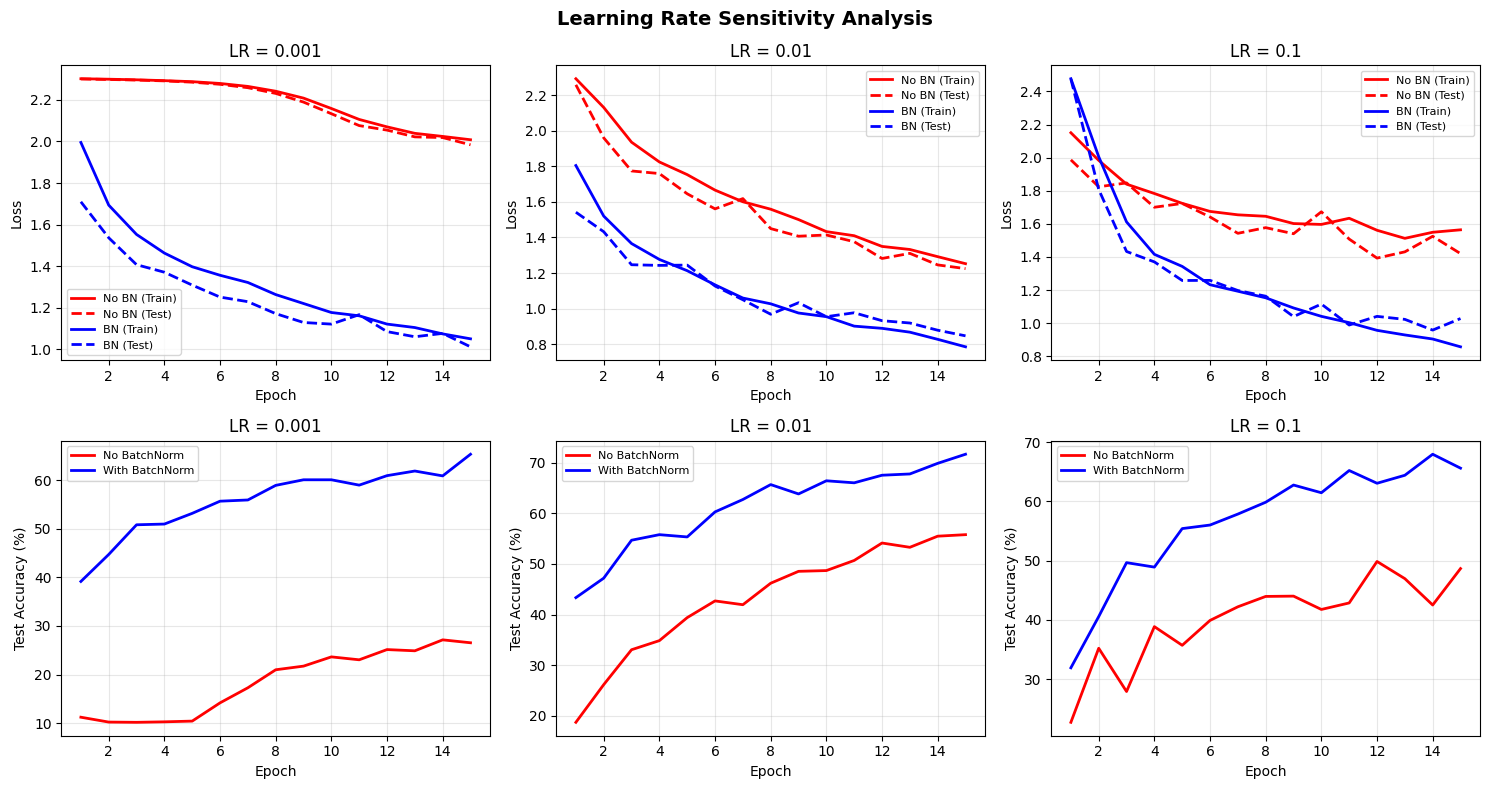


FINAL TEST ACCURACY BY LEARNING RATE
LR         Without BN           With BN              Difference     
----------------------------------------------------------------------
0.001      26.55                65.30                +38.75         
0.01       55.80                71.70                +15.90         
0.1        48.65                65.60                +16.95         


In [16]:
def plot_lr_comparison(lr_results):
    """Visualize learning rate sensitivity."""
    
    learning_rates = list(lr_results['no_bn'].keys())
    
    fig, axes = plt.subplots(2, len(learning_rates), figsize=(5*len(learning_rates), 8))
    
    colors_no_bn = plt.cm.Reds(np.linspace(0.4, 0.8, len(learning_rates)))
    colors_bn = plt.cm.Blues(np.linspace(0.4, 0.8, len(learning_rates)))
    
    for i, lr in enumerate(learning_rates):
        # Loss
        ax = axes[0, i]
        
        if lr_results['no_bn'][lr]:
            epochs = range(1, len(lr_results['no_bn'][lr]['train_loss']) + 1)
            ax.plot(epochs, lr_results['no_bn'][lr]['train_loss'], 
                   color='red', linestyle='-', linewidth=2, label='No BN (Train)')
            ax.plot(epochs, lr_results['no_bn'][lr]['test_loss'],
                   color='red', linestyle='--', linewidth=2, label='No BN (Test)')
        
        if lr_results['with_bn'][lr]:
            epochs = range(1, len(lr_results['with_bn'][lr]['train_loss']) + 1)
            ax.plot(epochs, lr_results['with_bn'][lr]['train_loss'],
                   color='blue', linestyle='-', linewidth=2, label='BN (Train)')
            ax.plot(epochs, lr_results['with_bn'][lr]['test_loss'],
                   color='blue', linestyle='--', linewidth=2, label='BN (Test)')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'LR = {lr}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Accuracy
        ax = axes[1, i]
        
        if lr_results['no_bn'][lr]:
            epochs = range(1, len(lr_results['no_bn'][lr]['test_acc']) + 1)
            ax.plot(epochs, lr_results['no_bn'][lr]['test_acc'],
                   color='red', linewidth=2, label='No BatchNorm')
        
        if lr_results['with_bn'][lr]:
            epochs = range(1, len(lr_results['with_bn'][lr]['test_acc']) + 1)
            ax.plot(epochs, lr_results['with_bn'][lr]['test_acc'],
                   color='blue', linewidth=2, label='With BatchNorm')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Test Accuracy (%)')
        ax.set_title(f'LR = {lr}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Learning Rate Sensitivity Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "=" * 70)
    print("FINAL TEST ACCURACY BY LEARNING RATE")
    print("=" * 70)
    print(f"{'LR':<10} {'Without BN':<20} {'With BN':<20} {'Difference':<15}")
    print("-" * 70)
    
    for lr in learning_rates:
        no_bn_acc = lr_results['no_bn'][lr]['test_acc'][-1] if lr_results['no_bn'][lr] else float('nan')
        bn_acc = lr_results['with_bn'][lr]['test_acc'][-1] if lr_results['with_bn'][lr] else float('nan')
        diff = bn_acc - no_bn_acc
        print(f"{lr:<10} {no_bn_acc:<20.2f} {bn_acc:<20.2f} {diff:<+15.2f}")

plot_lr_comparison(lr_results)

## 8. Experiment 4: Internal Covariate Shift Visualization

Let's directly visualize what "internal covariate shift" looks like by recording activation histograms at the start and end of training.

In [17]:
def capture_activations(model, dataloader, layer_names, num_batches=5):
    """Capture activation distributions from a model."""
    model.eval()
    
    activations = {name: [] for name in layer_names}
    hooks = []
    
    def make_hook(name):
        def hook(module, input, output):
            activations[name].append(output.detach().cpu().numpy().flatten())
        return hook
    
    # Register hooks
    for name, module in model.named_modules():
        if name in layer_names:
            hooks.append(module.register_forward_hook(make_hook(name)))
    
    # Forward pass
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            _ = model(inputs)
    
    # Remove hooks
    for h in hooks:
        h.remove()
    
    # Concatenate activations
    return {name: np.concatenate(acts) for name, acts in activations.items()}

Capturing activations before and after training...
  Before training...
  Training for 5 epochs...
  After training...


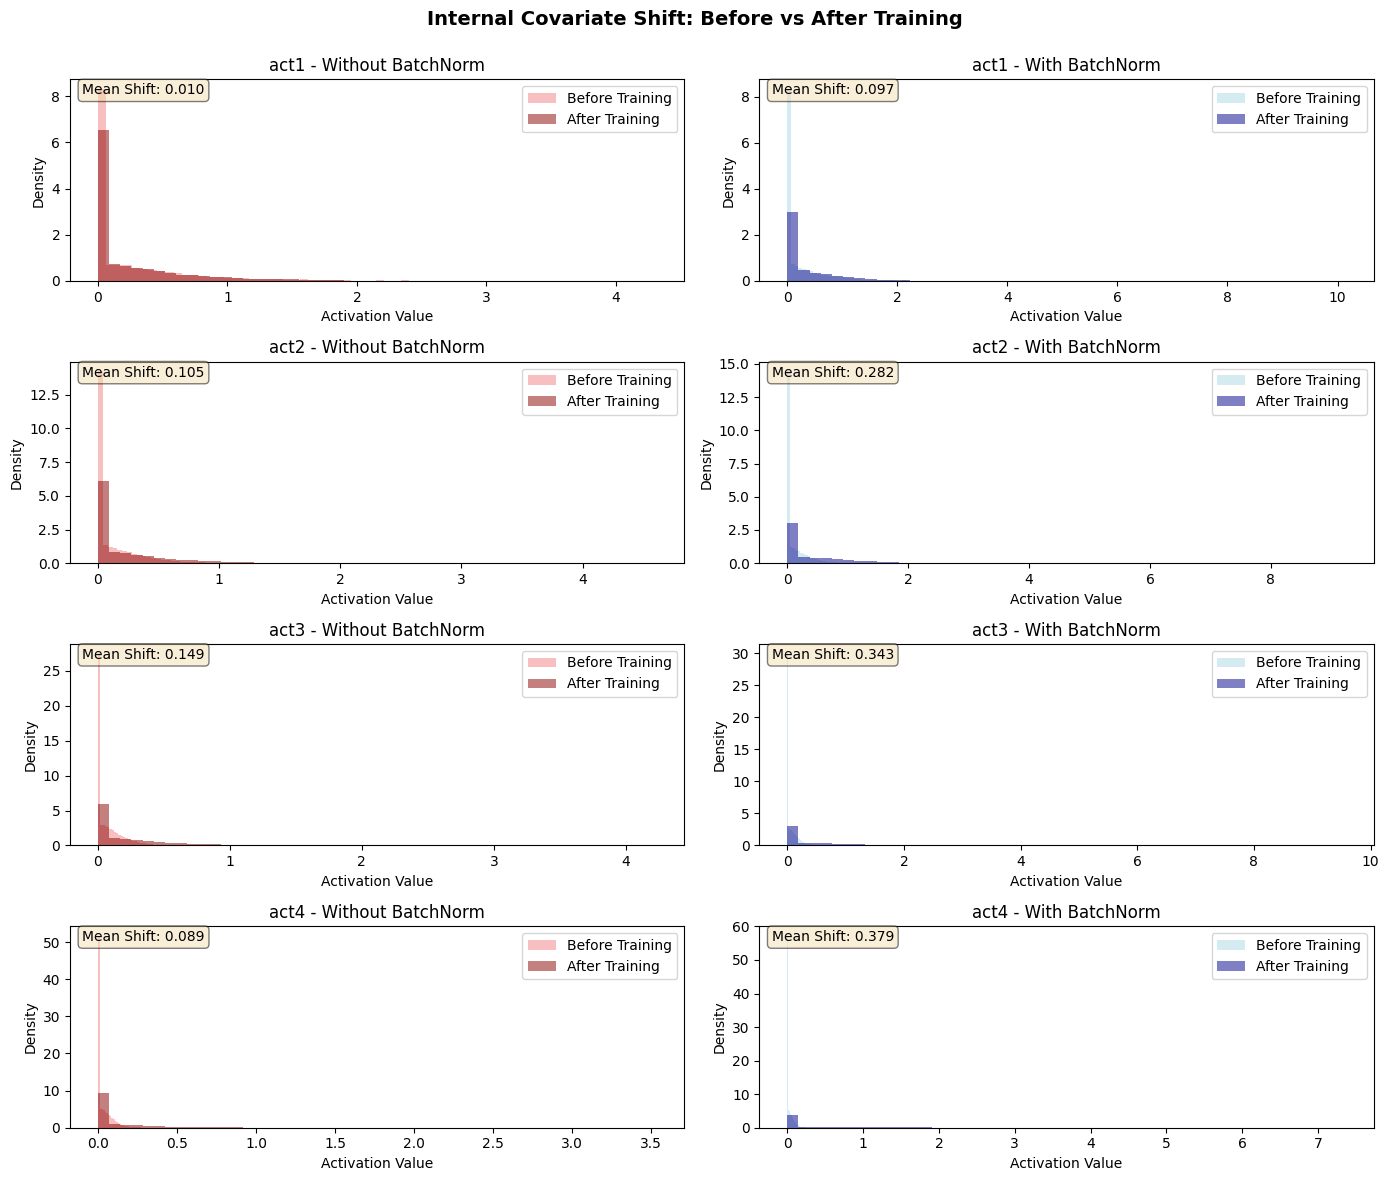

In [20]:
def plot_internal_covariate_shift():
    """
    Visualize internal covariate shift by comparing activation distributions
    before and after training.
    """
    print("Capturing activations before and after training...")
    
    # Create fresh models
    model_no_bn = CNN_NoBatchNorm().to(device)
    model_bn = CNN_WithBatchNorm().to(device)
    
    layers = ['act1', 'act2', 'act3', 'act4']
    
    # Capture activations BEFORE training
    print("  Before training...")
    acts_no_bn_before = capture_activations(model_no_bn, trainloader, layers)
    acts_bn_before = capture_activations(model_bn, trainloader, layers)
    
    # Quick training (just 5 epochs to show the shift)
    print("  Training for 5 epochs...")
    criterion = nn.CrossEntropyLoss()
    
    for model, name in [(model_no_bn, 'No BN'), (model_bn, 'With BN')]:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        model.train()
        
        for epoch in range(5):
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
    # Capture activations AFTER training
    print("  After training...")
    acts_no_bn_after = capture_activations(model_no_bn, trainloader, layers)
    acts_bn_after = capture_activations(model_bn, trainloader, layers)
    
    # Plot
    fig, axes = plt.subplots(len(layers), 2, figsize=(14, 3*len(layers)))
    
    for i, layer in enumerate(layers):
        # Without BatchNorm
        ax = axes[i, 0]
        ax.hist(acts_no_bn_before[layer], bins=50, alpha=0.5, density=True, 
               label='Before Training', color='lightcoral')
        ax.hist(acts_no_bn_after[layer], bins=50, alpha=0.5, density=True,
               label='After Training', color='darkred')
        ax.set_title(f'{layer} - Without BatchNorm')
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Density')
        ax.legend()
        
        # Compute shift statistics
        shift = abs(np.mean(acts_no_bn_after[layer]) - np.mean(acts_no_bn_before[layer]))
        ax.text(0.02, 0.98, f'Mean Shift: {shift:.3f}', transform=ax.transAxes, 
               verticalalignment='top', fontsize=10, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # With BatchNorm
        ax = axes[i, 1]
        ax.hist(acts_bn_before[layer], bins=50, alpha=0.5, density=True,
               label='Before Training', color='lightblue')
        ax.hist(acts_bn_after[layer], bins=50, alpha=0.5, density=True,
               label='After Training', color='darkblue')
        ax.set_title(f'{layer} - With BatchNorm')
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Density')
        ax.legend()
        
        # Compute shift statistics
        shift = abs(np.mean(acts_bn_after[layer]) - np.mean(acts_bn_before[layer]))
        ax.text(0.02, 0.98, f'Mean Shift: {shift:.3f}', transform=ax.transAxes,
               verticalalignment='top', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Internal Covariate Shift: Before vs After Training\n',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_internal_covariate_shift()

## 9. Key Insights and Conclusions

### What We Learned:

1. **Internal Covariate Shift**
   - Without BatchNorm, activation distributions shift dramatically during training
   - Each layer must constantly adapt to changing input distributions
   - BatchNorm stabilizes these distributions, making optimization easier

2. **Learning Rate Tolerance**
   - Without BatchNorm: High learning rates cause training instability or divergence
   - With BatchNorm: Models can use much higher learning rates
   - This leads to faster convergence and often better final performance

3. **Gradient Flow**
   - BatchNorm helps maintain healthy gradient magnitudes across layers
   - Reduces both vanishing and exploding gradient problems
   - Makes deep networks much easier to train

4. **Regularization Effect**
   - BatchNorm adds noise during training (mini-batch statistics vary)
   - This acts as a regularizer, often reducing the need for dropout

### When to Use BatchNorm:
- Deep networks (3+ layers)
- When using high learning rates
- When training is unstable
- Most CNN and MLP architectures

### When BatchNorm May Not Help:
- Very small batch sizes (< 8)
- Sequential models where batch statistics don't make sense
- Some RL applications where batch independence matters

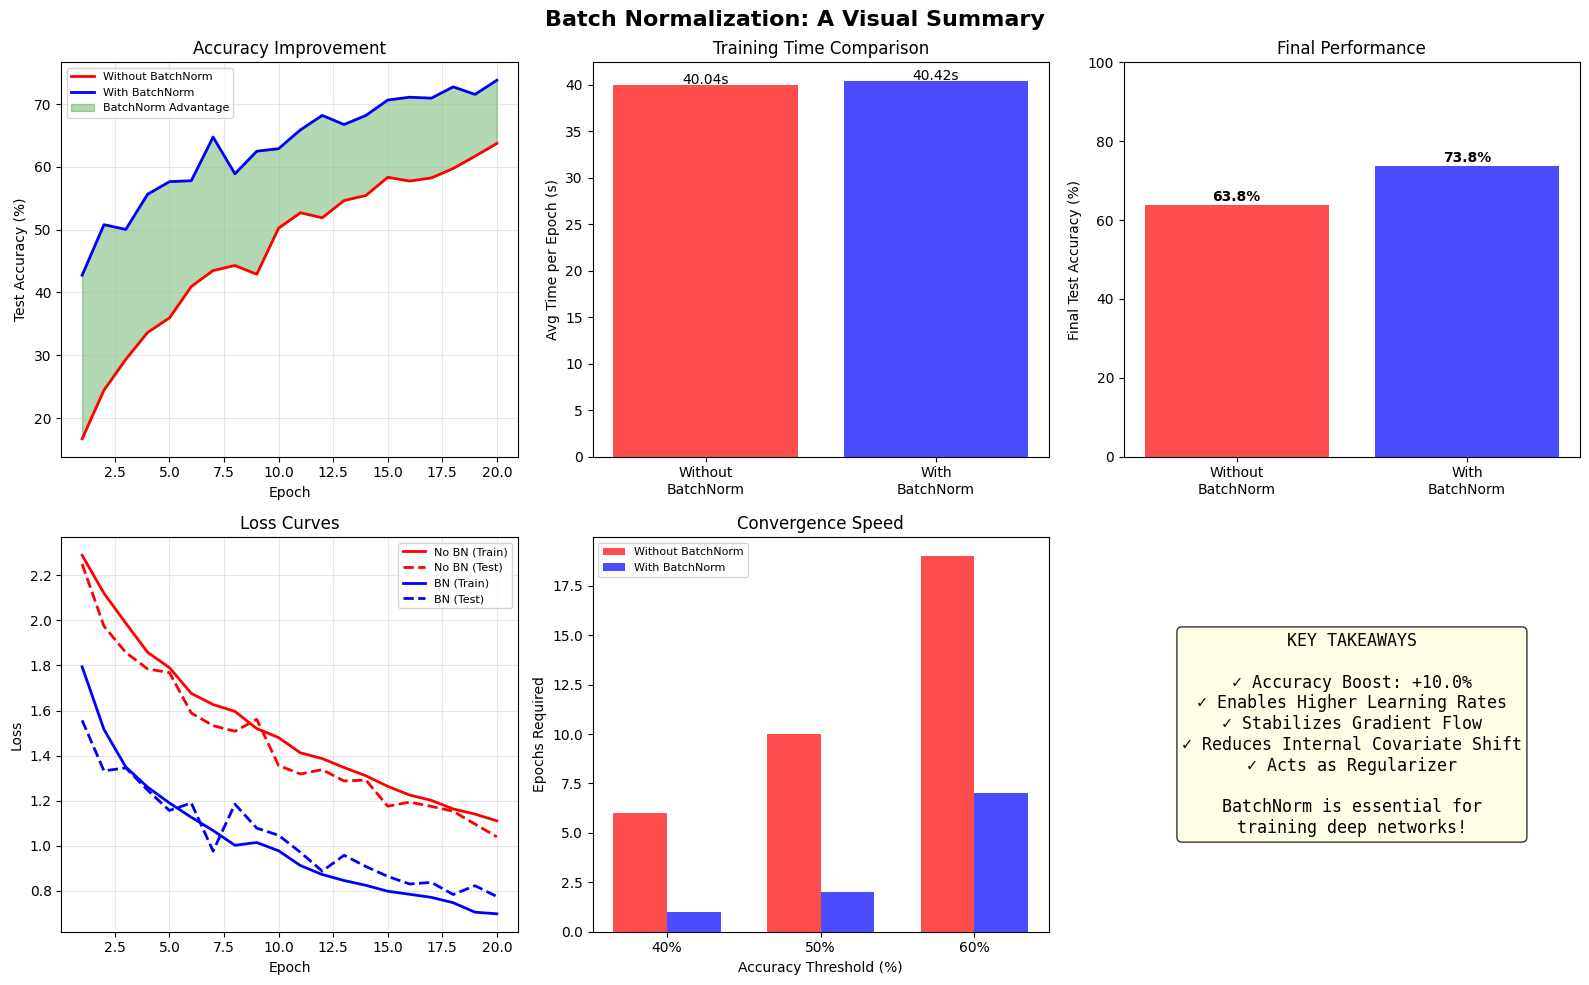

In [19]:
# Final summary visualization
def create_summary_figure(history_no_bn, history_with_bn):
    """Create a comprehensive summary figure."""
    
    fig = plt.figure(figsize=(16, 10))
    
    # Title
    fig.suptitle('Batch Normalization: A Visual Summary', fontsize=16, fontweight='bold')
    
    # 1. Test Accuracy Comparison
    ax1 = fig.add_subplot(2, 3, 1)
    epochs = range(1, len(history_no_bn['test_acc']) + 1)
    ax1.plot(epochs, history_no_bn['test_acc'], 'r-', linewidth=2, label='Without BatchNorm')
    ax1.plot(epochs, history_with_bn['test_acc'], 'b-', linewidth=2, label='With BatchNorm')
    ax1.fill_between(epochs, history_no_bn['test_acc'], history_with_bn['test_acc'], 
                     alpha=0.3, color='green', label='BatchNorm Advantage')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.set_title('Accuracy Improvement')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Training Speed (time per epoch)
    ax2 = fig.add_subplot(2, 3, 2)
    x = ['Without\nBatchNorm', 'With\nBatchNorm']
    times = [np.mean(history_no_bn['epoch_time']), np.mean(history_with_bn['epoch_time'])]
    bars = ax2.bar(x, times, color=['red', 'blue'], alpha=0.7)
    ax2.set_ylabel('Avg Time per Epoch (s)')
    ax2.set_title('Training Time Comparison')
    for bar, time in zip(bars, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time:.2f}s', ha='center', fontsize=10)
    
    # 3. Final Accuracy Comparison
    ax3 = fig.add_subplot(2, 3, 3)
    final_accs = [history_no_bn['test_acc'][-1], history_with_bn['test_acc'][-1]]
    bars = ax3.bar(x, final_accs, color=['red', 'blue'], alpha=0.7)
    ax3.set_ylabel('Final Test Accuracy (%)')
    ax3.set_title('Final Performance')
    ax3.set_ylim(0, 100)
    for bar, acc in zip(bars, final_accs):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', fontsize=10, fontweight='bold')
    
    # 4. Loss Curves
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.plot(epochs, history_no_bn['train_loss'], 'r-', linewidth=2, label='No BN (Train)')
    ax4.plot(epochs, history_no_bn['test_loss'], 'r--', linewidth=2, label='No BN (Test)')
    ax4.plot(epochs, history_with_bn['train_loss'], 'b-', linewidth=2, label='BN (Train)')
    ax4.plot(epochs, history_with_bn['test_loss'], 'b--', linewidth=2, label='BN (Test)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.set_title('Loss Curves')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # 5. Convergence Speed (epochs to reach 50% accuracy)
    ax5 = fig.add_subplot(2, 3, 5)
    
    def epochs_to_threshold(accs, threshold=50):
        for i, acc in enumerate(accs):
            if acc >= threshold:
                return i + 1
        return len(accs)
    
    thresholds = [40, 50, 60]
    no_bn_epochs = [epochs_to_threshold(history_no_bn['test_acc'], t) for t in thresholds]
    bn_epochs = [epochs_to_threshold(history_with_bn['test_acc'], t) for t in thresholds]
    
    x_pos = np.arange(len(thresholds))
    width = 0.35
    ax5.bar(x_pos - width/2, no_bn_epochs, width, label='Without BatchNorm', color='red', alpha=0.7)
    ax5.bar(x_pos + width/2, bn_epochs, width, label='With BatchNorm', color='blue', alpha=0.7)
    ax5.set_xlabel('Accuracy Threshold (%)')
    ax5.set_ylabel('Epochs Required')
    ax5.set_title('Convergence Speed')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels([f'{t}%' for t in thresholds])
    ax5.legend(fontsize=8)
    
    # 6. Key Takeaways
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.axis('off')
    
    improvement = history_with_bn['test_acc'][-1] - history_no_bn['test_acc'][-1]
    
    takeaways = [
        "KEY TAKEAWAYS",
        "",
        f"\u2713 Accuracy Boost: +{improvement:.1f}%",
        "\u2713 Enables Higher Learning Rates",
        "\u2713 Stabilizes Gradient Flow",
        "\u2713 Reduces Internal Covariate Shift",
        "\u2713 Acts as Regularizer",
        "",
        "BatchNorm is essential for",
        "training deep networks!",
    ]
    
    ax6.text(0.5, 0.5, '\n'.join(takeaways), transform=ax6.transAxes,
            fontsize=12, verticalalignment='center', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            family='monospace')
    
    plt.tight_layout()
    plt.show()

create_summary_figure(history_no_bn, history_with_bn)

## 10. Further Experiments (Optional)

Try these experiments to deepen your understanding:

1. **Layer Normalization vs Batch Normalization**: Compare on same architecture
2. **Very Deep Networks**: Try 10+ layers with and without BatchNorm
3. **Small Batch Sizes**: See when BatchNorm breaks down (batch size < 4)
4. **Running Mean/Var**: Explore the role of momentum in BatchNorm
5. **Position of BatchNorm**: Before vs After activation function